In [1]:
import json
from operator import itemgetter
from itertools import groupby
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

In [4]:
with open('INDEX_general_PL_data.2017') as f:
    index = [l.strip().split() for l in f if not l.startswith('#')]
index = [[i[0], i[3], i[7][1:-1]] for i in index]
index = sorted(index, key=itemgetter(2))

In [5]:
ligand_groups = {k: [(item[0], item[1]) for item in g] for k, g in groupby(index, key=itemgetter(2))}

In [6]:
test_ligands = [l for l in ligand_groups if len(ligand_groups[l]) > 3 and len(l)==3]

In [7]:
binding_data = pd.read_csv('../data/pdbbind_2018_general_binding_data_clean.csv', index_col=0, squeeze=True)
rdkit_features = pd.read_csv('../data/pdbbind_2018_general_rdkit_features_clean.csv', index_col=0)
rfscore_features = pd.read_csv('../data/pdbbind_2018_general_rfscore_features_clean.csv', index_col=0)
nnscore_features = pd.read_csv('../data/pdbbind_2018_general_binana_features_clean.csv', index_col=0)

vina_terms = pd.Index(['vina_gauss1', 'vina_gauss2', 'vina_repulsion', 'vina_hydrogen', 'vina_hydrophobic', 'num_rotors'])
vina_features = nnscore_features.loc[:, vina_terms]
rfscorev3_features = pd.concat([rfscore_features, vina_features], axis='columns', join='inner')
rfscorev3_rdkit_features = pd.concat([rfscorev3_features, rdkit_features], axis='columns').drop('NumRotatableBonds', axis='columns')

In [8]:
pdbs_to_use = binding_data.index.intersection(rdkit_features.index).intersection(rfscore_features.index).intersection(rfscorev3_features.index).intersection(nnscore_features.index)

In [9]:
measured = {}
rdkit_predictions = {}
#rfscore_predictions = {}
rfscorev3_predictions = {}
#rfscorev3_rdkit_predictions = {}
#nnscore_predictions = {}
#vina_predictions = {}

for l in test_ligands:
    
    test_pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in pdbs_to_use]
    if not test_pdbs:
        test_ligands.remove(l)
        continue
        
    train_pdbs = [pdb for pdb in pdbs_to_use if pdb not in test_pdbs]
    y_train = binding_data.loc[train_pdbs].values.ravel()
    y_test = binding_data.loc[test_pdbs]
    measured[l] = y_test
    
    X_train = rdkit_features.loc[train_pdbs]
    X_test = rdkit_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    rdkit_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)
    '''
    X_train = vina_features.loc[train_pdbs]
    X_test = vina_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    vina_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)

    X_train = rfscore_features.loc[train_pdbs]
    X_test = rfscore_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    rfscore_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)
    '''
    
    X_train = rfscorev3_features.loc[train_pdbs]
    X_test = rfscorev3_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    rfscorev3_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)
    '''
    X_train = nnscore_features.loc[train_pdbs]
    X_test = nnscore_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    nnscore_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)
    
    
    # For comparison
    X_train = rfscorev3_rdkit_features.loc[train_pdbs]
    X_test = rfscorev3_rdkit_features.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=-1).fit(X_train, y_train)
    rfscorev3_rdkit_predictions[l] = pd.Series(data=rf.predict(X_test), index=test_pdbs)
    '''

In [23]:
correlation = {}

for l in measured:
    correlation[l] = {}
    #correlation[l]['Vina'] = pearsonr(measured[l].values.ravel(), vina_predictions[l].values.ravel())[0]
    #correlation[l]['RF-Score'] = pearsonr(measured[l].values.ravel(), rfscore_predictions[l].values.ravel())[0]
    correlation[l]['RF-Score v3'] = pearsonr(measured[l].values.ravel(), rfscorev3_predictions[l].values.ravel())[0]
    #correlation[l]['NNScore 2.0'] = pearsonr(measured[l].values.ravel(), nnscore_predictions[l].values.ravel())[0]

/data/griffin/fboyles/miniconda3/envs/the-lig/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/data/griffin/fboyles/miniconda3/envs/the-lig/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)


In [24]:
correlation = pd.DataFrame(correlation).T.dropna(how='any')
n_structs = pd.Series({l: len(measured[l]) for l in measured if l in correlation.index}).sort_values(ascending=False)
idx = {l: f'{l} (n={n})' for l, n in zip(n_structs.index, n_structs.values)}
correlation = correlation.loc[n_structs.index, ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']].rename(index=idx)

In [25]:
adp = rfscorev3_predictions['ADP'].index
adp_rdkit = rdkit_predictions['ADP'].iloc[0]

In [26]:
x = binding_data.loc[adp].values.ravel()
y1 = rfscorev3_predictions['ADP'].values.ravel()
y2 = rfscorev3_rdkit_predictions['ADP'].values.ravel()

(1, 9)

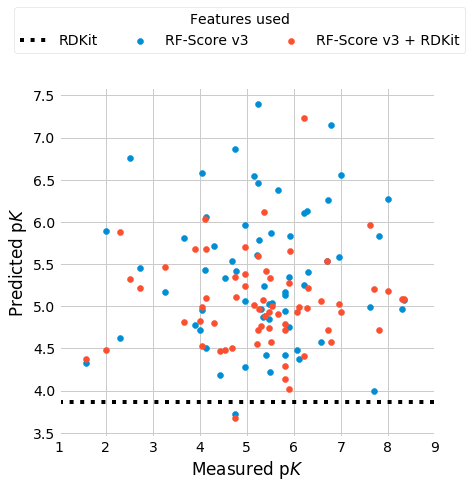

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.axhline(y=adp_rdkit, linestyle=':', color='k', label='RDKit')

ax.scatter(x, y1, label='RF-Score v3')
ax.scatter(x, y2, label='RF-Score v3 + RDKit')
ax.set_xlabel(r'Measured p$K$')
ax.set_ylabel(r'Predicted p$K$')
ax.legend(title='Features used', bbox_to_anchor=(1.1, 1.25), ncol=3)

ax.set_xlim(1, 9)
#fig.savefig('../figures/ADP_predictions.eps', dpi=350, bbox_inches='tight')

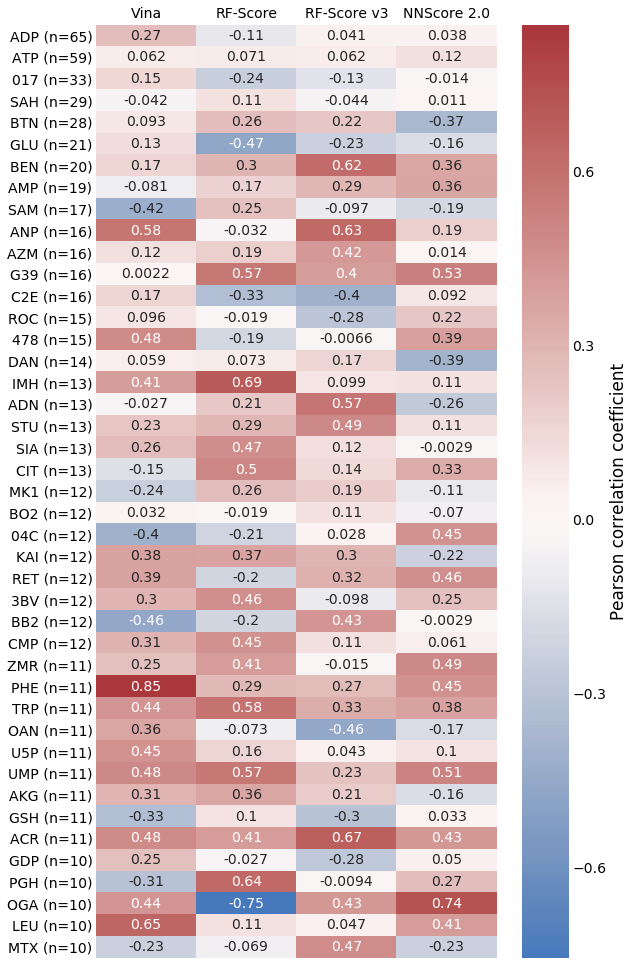

In [29]:
idx = [f'{l} (n={n})' for l, n in zip(n_structs.index, n_structs.values) if n > 9]

fig, ax = plt.subplots(1,1,figsize=(8, 16))
sns.heatmap(correlation.loc[idx], annot=True, ax=ax, cmap='vlag', cbar_kws={'label': 'Pearson correlation coefficient'}, center=0)
ax.xaxis.tick_top()
#fig.savefig('../figures/per_ligand_pearson_correlation_coefficient.eps', dpi=350, bbox_inches='tight')

In [20]:
rdkit_all_results = pd.concat([rdkit_predictions[l] for l in rdkit_predictions])
#vina_all_results = pd.concat([vina_predictions[l] for l in vina_predictions])
#rfscore_all_results = pd.concat([rfscore_predictions[l] for l in rfscore_predictions])
rfscorev3_all_results = pd.concat([rfscorev3_predictions[l] for l in rfscorev3_predictions])
#nnscore_all_results = pd.concat([nnscore_predictions[l] for l in nnscore_predictions])

#all_results = pd.concat([rdkit_all_results, vina_all_results, rfscore_all_results, rfscorev3_all_results, nnscore_all_results], axis='columns')
#all_results.columns = ['RDKit', 'Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']
all_results = pd.concat([rdkit_all_results, rfscorev3_all_results], axis='columns')
all_results.columns = ['RDKit', 'RF-Score v3']

#all_results.to_csv('../dumps/pdbbind_2017_general_single_ligand_predictions.csv')

In [21]:
#all_results = pd.read_csv('../dumps/pdbbind_2017_general_single_ligand_predictions.csv', index_col=0)

Build dataframes to create swarm plots.

In [22]:
dfs = {}

for feats in ['RF-Score v3']:#['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:

    temp = {}
    for l in test_ligands:
        pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in all_results.index]
        if len(pdbs) == 0:
            continue
        temp[l] = all_results.loc[pdbs, feats].rename(l)
        
    dfs[feats] = pd.concat(temp, axis='columns', sort=False)

In [23]:
temp = {}

for l in test_ligands:
    pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in rdkit_all_results.index]
    if len(pdbs) == 0:
        continue
    temp[l] = binding_data.loc[pdbs].rename(l)
dfs['Measured'] = pd.concat([temp[l] for l in temp], axis='columns', sort=False)

List ligand-based prediction for each ligand.

In [24]:
lb_prediction = {}

for l in test_ligands:
    pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in rdkit_all_results.index]
    if len(pdbs) == 0:
        continue
    lb_prediction[l] = rdkit_all_results.loc[pdbs[0]]
    
lb_prediction = pd.Series(lb_prediction).sort_values()

In [25]:
pdbs_to_plot = {l: [pdb for pdb, _ in ligand_groups[l] if pdb in rdkit_all_results.index] for l in test_ligands}
to_plot = pd.Index([l for l in test_ligands if len(ligand_groups[l]) > 10 and len(pdbs_to_plot[l]) > 1 and len(l)==3])

# Where do LB predictions lie within the distribution of p$K$ values for each ligand?

In [41]:
def swarm(df, series, label=None, to_plot=None, ax=None):
    if ax is None:
        ax = plt.gca()
        
    if to_plot is None:
        to_plot = series.index
        
    # Plot swarm plot of predictions per ligand, sorted by value of ligand-based predictions
    y = series.loc[to_plot].sort_values()
    swarms = df.loc[:, y.index]
    sns.swarmplot(data=swarms, ax=ax, linewidth=2, zorder=1, edgecolor='k', color='w', alpha=0.7, orient='v', label=label)
    
    # Plot lb predictions
    x = ax.get_xticks()
    ax.scatter(x, y, marker='*', s=450, label='Ligand-only model prediction', alpha=1, color='red', edgecolors='k', linewidth=2, zorder=2)#color='#008fd5'
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1][:2], labels[::-1][:2])

    #ax.legend(loc='upper right')
    ax.set_xlabel('Ligand')
    ax.set_ylabel('Affinity (p$K$)')
    ax.set_ylim(-0.5, 15.5)
    
    return ax

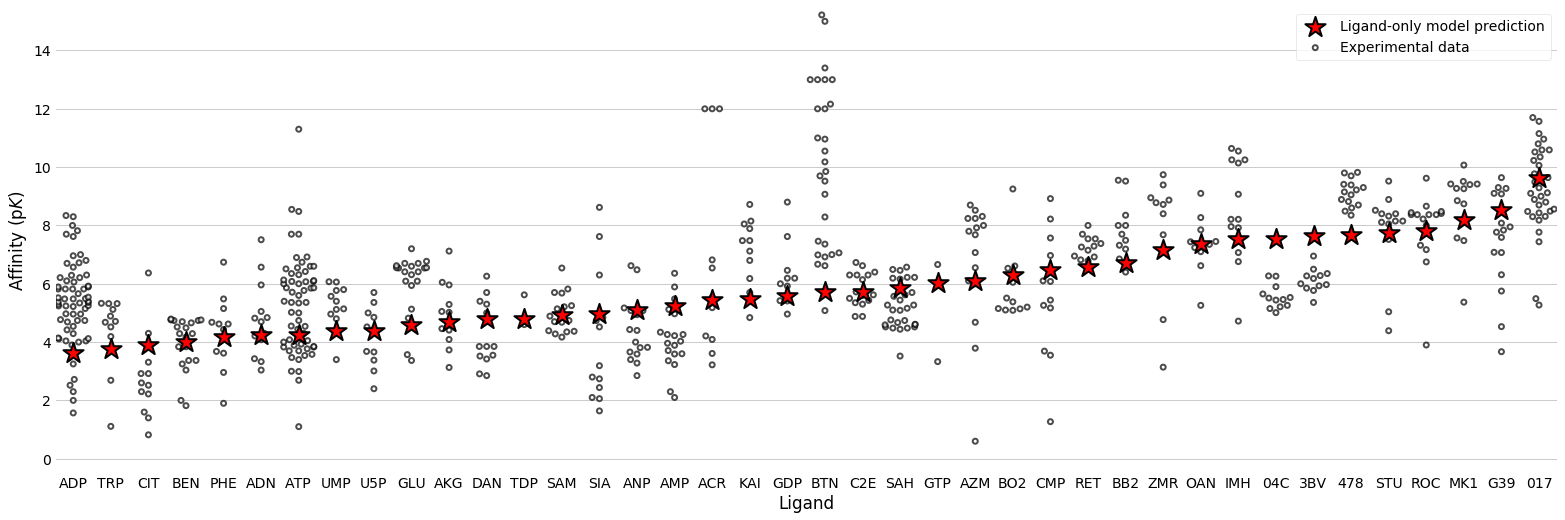

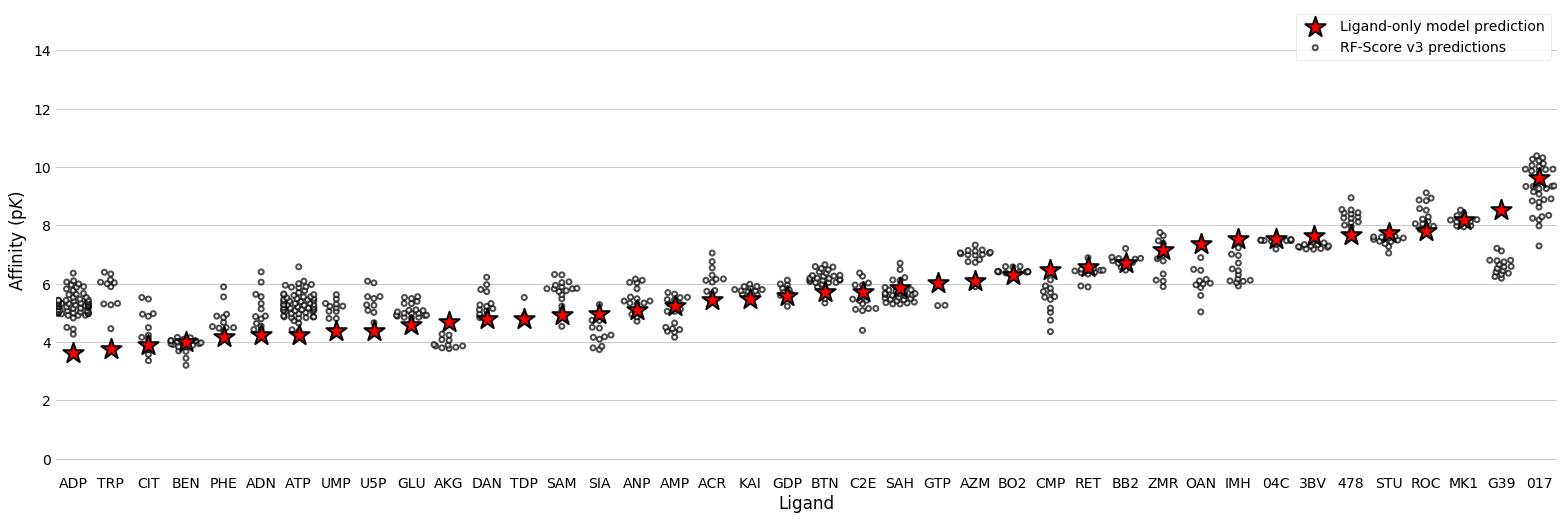

In [42]:
fig, ax = plt.subplots(1,1,figsize=(24,8))
swarm(dfs['Measured'], lb_prediction, label='Experimental data', to_plot=to_plot, ax=ax)
fig.savefig('../figures/ligand_based_prediction_against_measured_for_slides.jpg', dpi=350, bbox_inches='tight')
#fig, ax = plt.subplots(1,1,figsize=(24,8))
#swarm(dfs['Vina'], lb_prediction, to_plot=to_plot, ax=ax)
#fig.savefig('../figures/ligand_based_prediction_against_vina_rf.jpg', dpi=350, bbox_inches='tight')
#fig, ax = plt.subplots(1,1,figsize=(24,8))
#swarm(dfs['RF-Score'], lb_prediction, to_plot=to_plot, ax=ax)
#fig.savefig('../figures/ligand_based_prediction_against_rfscore.jpg', dpi=350, bbox_inches='tight')
fig, ax = plt.subplots(1,1,figsize=(24,8))
swarm(dfs['RF-Score v3'], lb_prediction, label='RF-Score v3 predictions', to_plot=to_plot, ax=ax)
fig.savefig('../figures/ligand_based_prediction_against_rfscorev3_for_slides.jpg', dpi=350, bbox_inches='tight')
#fig, ax = plt.subplots(1,1,figsize=(24,8))
#swarm(dfs['NNScore 2.0'], lb_prediction, to_plot=to_plot, ax=ax)
#fig.savefig('../figures/ligand_based_prediction_against_nnscore.jpg', dpi=350, bbox_inches='tight')

# Compute Tanimoto coefficient between Morgan Fingerprints for ligands

Morgan FP radius 2; size 2048.
Create a dataframe whose columns are the test ligands and whose rows are the TC to the ligand found in one PDB structure.

In [41]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint

mols = {}
fingerprints = {}
test_pdbs = {}

for l in test_ligands:
    pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in binding_data.index]
    for pdb in pdbs:
        src = f'/data/griffin/fboyles/pdbbind_2017/{pdb}/{pdb}_ligand.sdf'
        mol = next(Chem.SDMolSupplier(src))
        if mol is None:
            src = f'/data/griffin/fboyles/pdbbind_2017/{pdb}/{pdb}_ligand.mol2'
            mol = Chem.MolFromMol2File(src)
        if mol:
            mols[l] = mol
            fingerprints[l] = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            test_pdbs[l] = pdb
            break

all_mols = {}
all_fps = {}

for pdb in binding_data.index:
    src = f'/data/griffin/fboyles/pdbbind_2017/{pdb}/{pdb}_ligand.sdf'
    mol = next(Chem.SDMolSupplier(src))
    if mol is None:
        src = f'/data/griffin/fboyles/pdbbind_2017/{pdb}/{pdb}_ligand.mol2'
        mol = Chem.MolFromMol2File(src)
    all_mols[pdb] = mol
    all_fps[pdb] = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

similarity = {}

for pdb1 in binding_data.index:
    similarity[pdb1] = {}
    for pdb2 in binding_data.index:
        similarity[pdb1][pdb2] = DataStructs.FingerprintSimilarity(all_fps[pdb1], all_fps[pdb2])
        
mapper = {test_pdbs[l]: l for l in test_pdbs}
similarity_df = pd.DataFrame.from_dict(similarity).loc[:,[test_pdbs[l] for l in test_pdbs]].rename(mapper=mapper, axis='columns')

In [154]:
test_ligands = [l for l in test_pdbs if l not in exclude]

In [221]:
test_ligands = [l for l in test_pdbs if l not in exclude]
training_size = {}

for l in test_ligands:
    s = similarity_df[l]
    training_size[l] = {}
    training_size[l][1.0] = len(s.index)
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        training_size[l][i] = len(s[s<i].index)
training_size = pd.DataFrame.from_dict(training_size)

In [222]:
average_training_size = training_size.mean(axis='columns').astype(int)

In [214]:
averages = {}

for l in test_ligands:
    averages[l] = dfs['Measured'].loc[:, l].dropna().mean()

averages = pd.Series(averages)

Only ligands with identical HET-ID removed from training data

In [16]:
measured = {}
for l in test_ligands:
    test = test_pdbs[l]
    y_test = binding_data.loc[test]
    measured[l] = y_test['pK'].rename(l)
df = pd.concat([measured[l] for l in measured], join='outer', axis='columns', sort=False)

NameError: name 'test_pdbs' is not defined

# How does similarity between training and test ligands affect ligand-only model?

In [ ]:
training_pdbs_09 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.9]
    training_pdbs_09[l] = s.index
    
training_pdbs_08 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.8]
    training_pdbs_08[l] = s.index

training_pdbs_07 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.7]
    training_pdbs_07[l] = s.index
    
training_pdbs_06 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.6]
    training_pdbs_06[l] = s.index

training_pdbs_05 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.5]
    training_pdbs_05[l] = s.index

training_pdbs_04 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.4]
    training_pdbs_04[l] = s.index

training_pdbs_03 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.3]
    training_pdbs_03[l] = s.index

training_pdbs_02 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.2]
    training_pdbs_02[l] = s.index
    
training_pdbs_01 = {}
for l in test_ligands:
    s = similarity_df[l]
    s = s[s<0.1]
    training_pdbs_01[l] = s.index
    
test_pdbs = {}
for l in test_ligands:
    test_pdbs[l] = [pdb for pdb, _ in ligand_groups[l] if pdb in binding_data.index]

In [19]:
predictions_all = {}

for l in test_ligands:
    test_pdbs = [pdb for pdb, _ in ligand_groups[l] if pdb in binding_data.index]
    if not test_pdbs:
        test_ligands.remove(l)
        continue
    train_pdbs = [pdb for pdb in binding_data.index if pdb not in test_pdbs]
    X_train = rdkit_features.loc[train_pdbs]
    y_train = binding_data.loc[train_pdbs]
    X_test = rdkit_features.loc[test_pdbs].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test_pdbs]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_all[l] = rf.predict(X_test)[0]
with open('lbap_all_predictions.json', 'w') as f:
    json.dump(predictions_all, f)

In [20]:
predictions_09 = {}

for l in test_ligands:
    train = training_pdbs_09[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_09[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.9_predictions.json', 'w') as f:
    json.dump(predictions_09, f)

TypeError: list indices must be integers or slices, not str

In [ ]:
predictions_08 = {}

for l in test_ligands:
    train = training_pdbs_08[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_08[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.8_predictions.json', 'w') as f:
    json.dump(predictions_08, f)

In [ ]:
predictions_07 = {}

for l in test_ligands:
    train = training_pdbs_07[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_07[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.7_predictions.json', 'w') as f:
    json.dump(predictions_07, f)

In [ ]:
predictions_06 = {}

for l in test_ligands:
    train = training_pdbs_06[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_06[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.6_predictions.json', 'w') as f:
    json.dump(predictions_06, f)

In [ ]:
predictions_05 = {}

for l in test_ligands:
    train = training_pdbs_05[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_05[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.5_predictions.json', 'w') as f:
    json.dump(predictions_05, f)

In [ ]:
predictions_04 = {}

for l in test_ligands:
    train = training_pdbs_04[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_04[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.4_predictions.json', 'w') as f:
    json.dump(predictions_04, f)

In [ ]:
predictions_03 = {}

for l in test_ligands:
    train = training_pdbs_03[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_03[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.3_predictions.json', 'w') as f:
    json.dump(predictions_03, f)

In [ ]:
predictions_02 = {}

for l in test_ligands:
    train = training_pdbs_02[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_02[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.2_predictions.json', 'w') as f:
    json.dump(predictions_02, f)

In [ ]:
predictions_01 = {}

for l in test_ligands:
    train = training_pdbs_01[l]
    test = test_pdbs[l]
    X_train = rdkit_features.loc[train]
    y_train = binding_data.loc[train]
    X_test = rdkit_features.loc[test].iloc[0].values.reshape(1, -1)
    y_test = binding_data.loc[test]
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=16).fit(X_train, y_train.values.ravel())
    predictions_01[l] = rf.predict(X_test)[0]
with open('lbap_tc_0.1_predictions.json', 'w') as f:
    json.dump(predictions_01, f)

In [ ]:
rp = {}
x = averages.values
y = pd.Series(predictions_all).loc[averages.index]
rp[1.0] = pearsonr(x,y)[0]
y = pd.Series(predictions_09).loc[averages.index]
rp[0.9] = pearsonr(x,y)[0]
y = pd.Series(predictions_08).loc[averages.index]
rp[0.8] = pearsonr(x,y)[0]
y = pd.Series(predictions_07).loc[averages.index]
rp[0.7] = pearsonr(x,y)[0]
y = pd.Series(predictions_06).loc[averages.index]
rp[0.6] = pearsonr(x,y)[0]
y = pd.Series(predictions_05).loc[averages.index]
rp[0.5] = pearsonr(x,y)[0]
y = pd.Series(predictions_04).loc[averages.index]
rp[0.4] = pearsonr(x,y)[0]
y = pd.Series(predictions_03).loc[averages.index]
rp[0.3] = pearsonr(x,y)[0]
y = pd.Series(predictions_02).loc[averages.index]
rp[0.2] = pearsonr(x,y)[0]
y = pd.Series(predictions_01).loc[averages.index]
rp[0.1] = pearsonr(x,y)[0]
rp = pd.Series(rp)
rp = rp.sort_index(ascending=False)
average_training_size = average_training_size.sort_index(ascending=False)

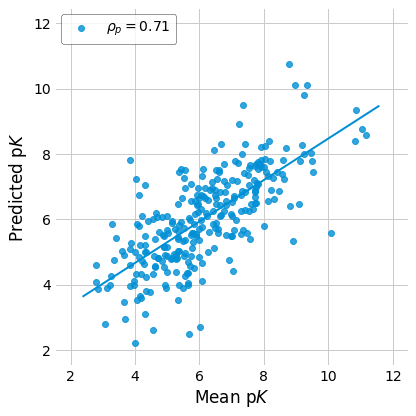

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
y = pd.Series(data=predictions_all, index=df.columns)
r, p = pearsonr(x, y)
sns.regplot(x=x, y=y, ax=ax, label=f'$\\rho_p = {r:.2f}$', color='#008fd5', line_kws={'lw': 2}, ci=None)
ax.set_xlabel(f'Mean p$K$')
ax.set_ylabel('Predicted p$K$')
ax.legend(loc='upper left', edgecolor='k')
ax.set_xlim([1.5, 12.5])
ax.set_ylim([1.5, 12.5])
fig.tight_layout()

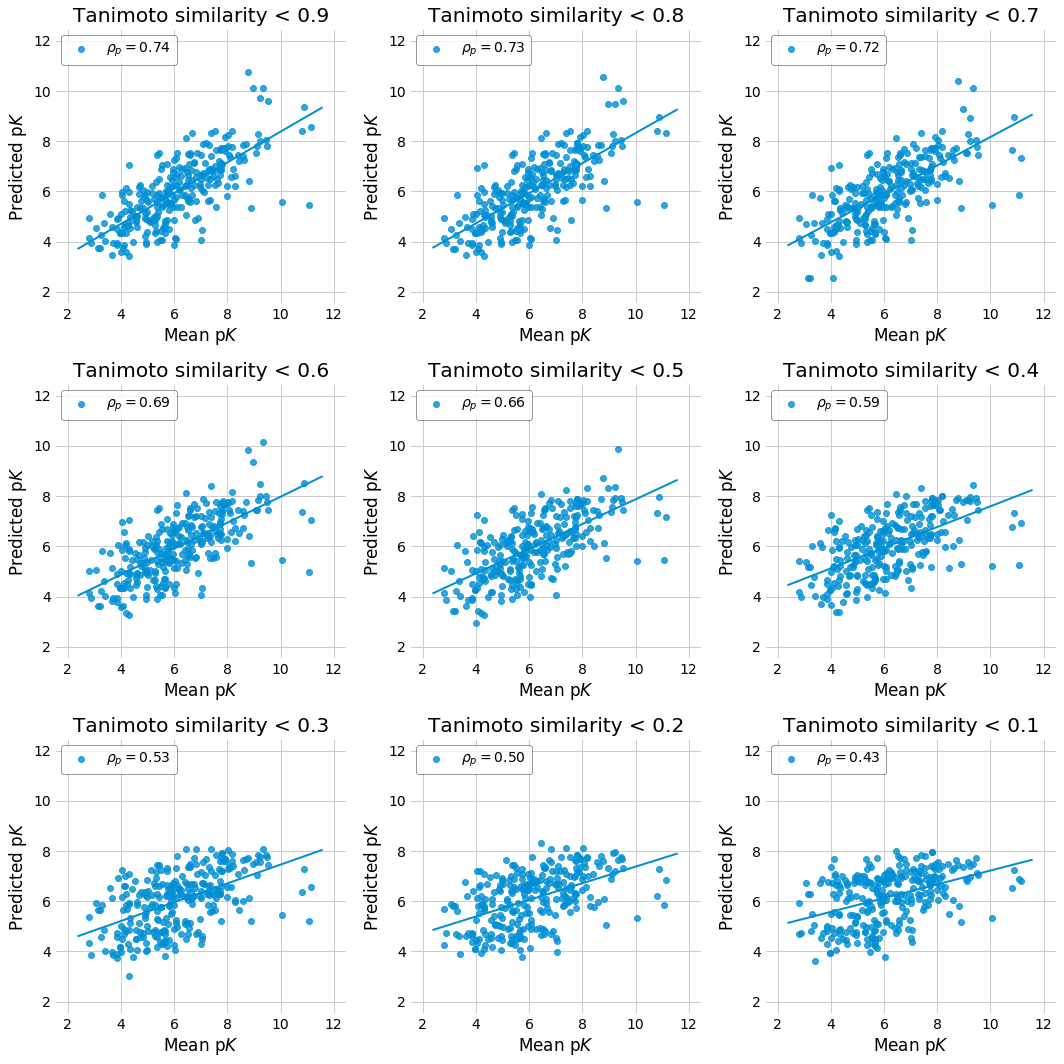

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
preds = [predictions_09, predictions_08, predictions_07, predictions_06, predictions_05, predictions_04, predictions_03, predictions_02, predictions_01]
#titles = ['TC < 0.9', 'TC < 0.8', 'TC < 0.7', 'TC < 0.6', 'TC < 0.5', 'TC < 0.4', 'TC < 0.3', 'TC < 0.2', 'TC < 0.1']
titles = [f'Tanimoto similarity < {t:.1f}' for t in np.arange(0.9, 0.0, -0.1)]
x = df.mean()
annots = iter(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
for pred, ax, title in zip(preds, axes.flatten(), titles):
    y = pd.Series(data=pred, index=df.columns)
    r, p = pearsonr(x, y)
    sns.regplot(x=x, y=y, ax=ax, label=f'$\\rho_p = {r:.2f}$', color='#008fd5', line_kws={'lw': 2}, ci=None)
    ax.set_xlabel(f'Mean p$K$')
    ax.set_ylabel('Predicted p$K$')
    ax.legend(loc='upper left', edgecolor='k')
    ax.set_title(title)
    ax.set_xlim([1.5, 12.5])
    ax.set_ylim([1.5, 12.5])
    ax.text(-0.1, 1.05, annot, transform=ax.transAxes, size=20, weight='bold')
fig.tight_layout()